In [1]:
#!pip install google-cloud-speech

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import librosa.display
import matplotlib.pyplot as plt


from Code.Misc.helper import *
from Code.Misc.features import *
from textblob import TextBlob

from tqdm import tqdm
import struct
%matplotlib inline


In [3]:
# load in model

PATH_TO_MODEL = "../Misc/Saved_data/Trained_models/2_layer_LSTM.pickle"

In [4]:
# read in wav file

In [5]:
import IPython.display as ipd
audio_path = "F:\Capstone Project\Capstone---RTSD-System\Data\CMU_MOSI\Raw\Audio\WAV_16000/Full/"
file_name = "0h-zjBukYpk.wav"

#ipd.Audio(audio_path + file_name) # load a local WAV file

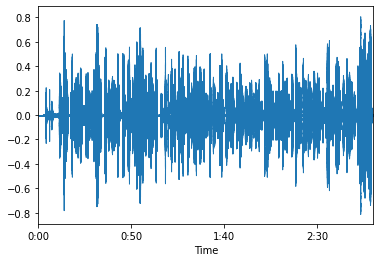

In [6]:
import librosa
import librosa.display

y, sr = librosa.load(audio_path + file_name) #, duration=10)
fig, ax = plt.subplots()
librosa.display.waveplot(y, sr=sr)
ax.label_outer()

In [7]:
wav = get_audio(audio_path, file_name)
(nchannels, sampwidth, framerate, nframes, comptype, compname), samples_wav = wav

In [8]:
import speech_recognition as sr
r = sr.Recognizer()
r.energy_threshold = 280

a_file = sr.AudioFile(audio_path + file_name)

In [9]:
# we split our audio into separate windows since this is how the final system will be implemented.

input_audio_file = sr.AudioFile(audio_path + file_name)

audio_list = []
length = 10 # window size in seconds
overlap = 5 # overlap with last window in seconds
with input_audio_file as source:
    dur = source.DURATION
    r.adjust_for_ambient_noise(source, duration=1)

for sample in tqdm(range(0, int(dur / length))):
    if sample > 0:
        # get the time for the start of the sample window
        # including overlap
        ptime_offset = sample * length - overlap
    else:
        # no offset for the first sample window
        ptime_offset = 0

    #print("sample: " + str(ptime_offset) + " - " + str(ptime_offset + length))
    with input_audio_file as source:
        audio_list.append(r.record(source, duration=length , offset = ptime_offset))

with input_audio_file as source:
    full_audio = r.record(source)

100%|██████████| 18/18 [00:00<00:00, 285.72it/s]


In [10]:
import deepspeech as ds

version_dir = "F:\Capstone Project\Capstone---RTSD-System/Code\Misc\Saved_data\Trained_models\deep_speech_models/"
model_file_8 = version_dir + "0.8.2/deepspeech-0.8.2-models.pbmm"
scorer_file_8 = version_dir + "0.8.2/deepspeech-0.8.2-models.scorer"

deepspeech_model_8 = ds.Model(model_file_8)
deepspeech_model_8.enableExternalScorer(scorer_file_8)

print("Sample_rate = " + str(deepspeech_model_8.sampleRate()))

Sample_rate = 16000


In [12]:
# here we go through the list of sample windows computed in the last cell
# each window is passed into the speech recognition method and the output + runtime
# is printed out
i = 0
save_wav = True

avg_time_google = 0
avg_time_ds = 0
for sample in tqdm(audio_list):
    if i > 0:
        ptime_offset = i * length - overlap
    else:
        ptime_offset = 0

    print("frame: " + str(ptime_offset) + " - " + str(ptime_offset + length))
    i += 1
    print("GOOGLE:")
    try:
        time_start = time.time()
        text = r.recognize_google(sample)
        print("\t" + str(text))
        # polarity is the average sentiment of the phrase that was spoken
        sentiment = TextBlob(text).polarity
        print("\tPolarity: " + str(sentiment))
    except:
        # if these in an error in the speech recognition method
        # (usually due to no speech being detected)
        # we just skip the sample.
        print("\t--- Skip ---")
    time_sr = time.time() - time_start

    print("\t" + str(round(time_sr, 2)) + " seconds")
    avg_time_google += time_sr

    print("DeepSpeech:")

    time_start = time.time()

    # create stream
    stream_context = deepspeech_model_8.createStream()

    # export data as a np array
    audio_data = np.frombuffer(sample.get_raw_data(), dtype=np.int16)

    # feed audio array to model
    stream_context.feedAudioContent(audio_data)

    # print output text
    text = stream_context.finishStream()
    print("\t" + str(text))

    time_sr = time.time() - time_start

    sentiment = TextBlob(text).polarity
    print("\tPolarity: " + str(sentiment))

    #if save_wav: wav_write("audio_export/" + str(text) + ".wav", rate=16000, data=audio_data)

    print("\t" + str(round(time_sr, 2)) + " seconds")
    avg_time_ds += time_sr


print("________________ \n" +
      "Average Time: " + str(round(avg_time_google/i, 2)) +
      " Average Time: " + str(round(avg_time_ds/i, 2)))

 56%|█████▌    | 10/18 [02:55<02:20, 17.58s/it]


frame: 0 - 10
GOOGLE:
	--- Skip ---
	0.92 seconds
DeepSpeech:
	okay
	Polarity: 0.5
	3.97 seconds
frame: 5 - 15
GOOGLE:
	hello is this
	Polarity: 0.0
	2.03 seconds
DeepSpeech:
	okay i was a carmelite here for a few expensive
	Polarity: -0.06666666666666667
	25.53 seconds
frame: 15 - 25
GOOGLE:
	--- Skip ---
	1.5 seconds
DeepSpeech:
	sing amen leave three ver daddy houston reread will i am a tailor cash
	Polarity: 0.0
	9.88 seconds
frame: 25 - 35
GOOGLE:
	and yes I just watched this a week ago most specifically July 27th
	Polarity: 0.5
	1.68 seconds
DeepSpeech:
	and just i just watched this a week ago most mistily july twenty seventh so whoever old free dollar theatre showing
	Polarity: 0.3333333333333333
	16.9 seconds
frame: 35 - 45
GOOGLE:
	X-Men member
	Polarity: 0.0
	2.15 seconds
DeepSpeech:
	not the title worth movie may says it all the movie shows the origins and back story of famed ex men member long bringin
	Polarity: 0.08333333333333333
	13.8 seconds
frame: 45 - 55
GOOGLE:
	I'm 

KeyboardInterrupt: 

In [13]:
# another speech recognition library
# this is still WIP
# import assemblyai
#
# aai = assemblyai.Client(token='2b1b7629874949439da1114c8387af30')
# path = 'F:\Capstone Project\Capstone---RTSD-System\Data\RAVDESS\Actor_01/03-01-01-01-01-01-01.wav'
# transcript = aai.transcribe(filename=path)



b'\x05\x00\xbd\xff\xba\xff\x0c\x00\t\x00\xa7\xff\xb1\xff\xe8\xff\xe8\xff\xdc\xff\x03\x00\xfd\xff\n\x00\xe2\xff\xd8\xff\x12\x00\x11\x007\x00L\x00L\x00@\x00b\x009\x00\xc2\xff\xa3\xff\xdb\xff\xf0\xff\xf1\xff\xe9\xff\xd6\xff\xb8\xff\xa2\xff\n\x00:\x00\x1c\x00\x03\x00p\x00y\x00\x16\x00\x1d\x00.\x00+\x00&\x00\x03\x00\xda\xff\xbe\xffz\xff\x9d\xff\x99\xff\xe3\xff$\x00\xd3\xff\xbf\xff\xec\xff4\x00\x17\x00\x13\x00\x1a\x00:\x007\x00(\x00\x17\x00\x03\x00\xec\xff%\x00\x18\x00\xde\xff\x1f\x00\x0c\x00\xef\xff\xcd\xff\xfe\xff\x0f\x00\xf5\xff\x12\x00K\x00M\x00"\x00B\x00\r\x00\xd4\xff\x04\x00E\x00\x03\x00\xdc\xff\xc7\xff\xcb\xff\xc5\xffh\xff\x81\xff\xfe\xff\x06\x00\x13\x008\x00\x1c\x00\x12\x001\x00M\x00\xff\xff\xf4\xffC\x00Z\x00\x19\x00\xe1\xff\xdf\xff\xd6\xff\xcb\xff\xb8\xff\xb9\xff\xd9\xff\xc7\xff\xd4\xff\xe1\xff\xc1\xff\xe9\xff/\x00&\x00\n\x00\x0e\x00%\x006\x00\x1a\x00\x05\x00\xff\xff\xd2\xff\xf1\xff\x1a\x00\xab\xff\x8c\xff\xb8\xff\xca\xff\xd4\xff\xdd\xff\xde\xff\xed\xffB\x00U\x00\x06\x00/\x00U\x00q\

In [ ]:
save_wav = False
avg_time = 0
for audio in audio_list:

    time_start = time.time()

    # create stream
    stream_context = deepspeech_model_8.createStream()

    # export data as a np array
    audio_data = np.frombuffer(audio.get_raw_data(), dtype=np.int16)

    # feed audio array to model
    stream_context.feedAudioContent(audio_data)

    # print output text
    text = stream_context.finishStream()
    print("\t" + str(text))

    time_sr = time.time() - time_start

    sentiment = TextBlob(text).polarity
    print("\tPolarity: " + str(sentiment))

    if save_wav: wav_write("audio_export/" + str(text) + ".wav", rate=16000, data=audio_data)

    print("\t" + str(round(time_sr, 2)) + " seconds")
    avg_time += time_sr

print("________________ \n" +
      "Average Time: " + str(round(avg_time/i, 2)))


In [ ]:
    time_start = time.time()
    text = r.recognize_google(sample)
    print("\t" + str(text))
    # polarity is the average sentiment of the phrase that was spoken
    sentiment = TextBlob(text).polarity
    print("\tPolarity: " + str(sentiment))
except:
    # if these in an error in the speech recognition method
    # (usually due to no speech being detected)
    # we just skip the sample.
    print("\t--- Skip ---")

time_sr = time.time() - time_start

In [ ]:
wav_write("audio_export/test_wav.wav", rate=16000, data=audio_data)
text

In [ ]:
# model_file_9 = version_dir + "0.9.3/deepspeech-0.9.3-models.pbmm"
# scorer_file_9 = version_dir + "0.9.3/deepspeech-0.9.3-models.scorer"
#
# deepspeech_model_9 = ds.Model(model_file_9)
# deepspeech_model_9.enableExternalScorer(scorer_file_9)

In [ ]:
# len(audio_list[0].get_raw_data())
audio_data = np.frombuffer(audio_list[0].get_raw_data(), dtype=np.int16)